In [20]:
import tifffile 
import os
import numpy as np
from phathom import utils

In [21]:
# working_dir = '/media/jswaney/SSD EVO 860/organoid_phenotyping/20181206_eF9_A34_1'
working_dir = '/media/jswaney/SSD EVO 860/organoid_phenotyping/20181210_eF9_A34_2'

In [22]:
# ventricle_seg = tifffile.imread(os.path.join(working_dir, 'syto16_4x_downsampled_vzseg_smoothed_binary.tif'))
ventricle_seg = tifffile.imread(os.path.join(working_dir, 'sox2_4x_downsampled_vzseg_binary_smooth1.tif'))
ventricle_seg.shape

(646, 619, 638)

In [23]:
# xy_down = 4
xy_down = 3.7

voxel_size = utils.read_voxel_size(os.path.join(working_dir, 'voxel_size.csv'))
voxel_size = (voxel_size[0],) + tuple([xy_down * d for d in voxel_size[1:]])
voxel_size

(2.052, 4.0034, 4.0034)

In [24]:
voxel_volume = np.asarray(voxel_size).prod()
voxel_volume

32.887838121120005

In [25]:
from scipy.ndimage import label

In [26]:
lbls, nb_ventricles = label(ventricle_seg)
nb_ventricles

40

# Custom measurements with scipy

In [84]:
from scipy.ndimage import find_objects

In [20]:
bboxes = find_objects(lbls)
len(bboxes)

62

In [24]:
for i, bbox in enumerate(bboxes):
    roi = lbls[bbox]
    loc = np.where(roi == i+1)
    mask = (roi[loc] > 0)
    # ...

(3008,)

# Simple measurements with skimage

In [27]:
from skimage.measure import regionprops

In [28]:
props = regionprops(lbls)

vol_voxels = [p.area for p in props]
vol_um3 = [v * voxel_volume for v in vol_voxels]
eq_diams = [p.equivalent_diameter for p in props]
centroids = [p.centroid for p in props]
euler_nums = [p.euler_number for p in props]
extents = [p.extent for p in props]
minor_lengths = [p.minor_axis_length for p in props]
major_lengths = [p.major_axis_length for p in props]
axis_ratio = [major / minor for major, minor in zip(major_lengths, minor_lengths)]
# solidity = [p.solidity for p in props]  # Sometimes this errors out

# Make table and plots

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

In [30]:
data = {'vol_vx': vol_voxels,
        'vol_um3': vol_um3,
        'eq_diam': eq_diams,
        'euler_num': euler_nums,
        'extent': extents,
        'minor_axis': minor_lengths,
        'major_axis': major_lengths,
        'axis_ratio': axis_ratio}

In [31]:
df = pd.DataFrame.from_dict(data)
df.head()

,vol_vx,vol_um3,eq_diam,euler_num,extent,minor_axis,major_axis,axis_ratio
0,51214,1.684318e+06,46.074789,1,0.145909,59.436482,104.778804,1.762870
1,2608,8.577148e+04,17.077973,1,0.475219,16.785247,29.530708,1.759325
2,377848,1.242660e+07,89.695950,1,0.247852,119.580703,206.602514,1.727725
3,65491,2.153857e+06,50.010477,1,0.167533,62.938739,122.353679,1.944012
4,229606,7.551245e+06,75.973395,1,0.126970,103.741398,160.662517,1.548683


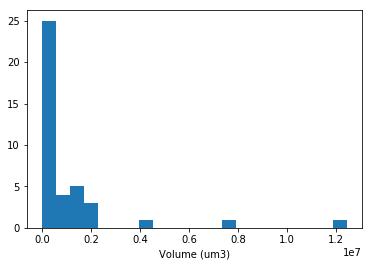

In [32]:
plt.hist(df['vol_um3'], bins=22)
plt.xlabel('Volume (um3)')
plt.show()

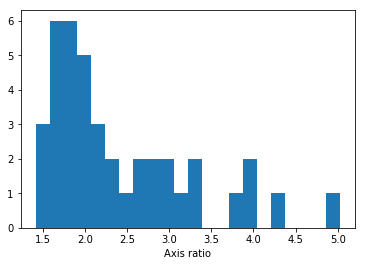

In [33]:
plt.hist(df['major_axis'] / df['minor_axis'], bins=22)
plt.xlabel('Axis ratio')
plt.show()

In [34]:
df.to_excel(os.path.join(working_dir, 'A34_2_ventricle_features.xlsx'))